In [2]:
import pandas as pd

In [12]:
nuc_enc_mean_data = pd.read_csv("nuc_encoded_mean_dataset.csv")

In [91]:
nuc_enc_median_data = pd.read_csv("nuc_encoded_median_dataset.csv")

In [13]:
nuc_enc_mean_data

,gene_id,nucleotide-1,nucleotide,nucleotide+1,transcript_id,position,dwell_1,std_1,mean_1,dwell_2,std_2,mean_2,dwell_3,std_3,mean_3,label
0,ENSG00000000003,4,14,9,ENST00000373020,512,0.007247,2.359500,86.795000,0.011177,2.496500,97.965000,0.008500,1.588750,92.330000,0.0
1,ENSG00000000003,18,0,0,ENST00000373020,689,0.009868,1.972857,102.495238,0.007332,2.551905,97.928571,0.006917,2.198571,89.385714,0.0
2,ENSG00000000003,4,12,0,ENST00000373020,823,0.007456,2.078095,86.904762,0.006193,1.912857,93.680952,0.007296,2.306667,88.176190,0.0
3,ENSG00000000003,4,13,4,ENST00000373020,830,0.007765,2.834000,86.765000,0.007522,3.192500,93.075000,0.005923,2.020500,80.110000,0.0
4,ENSG00000000003,16,13,5,ENST00000373020,849,0.006785,2.926667,86.923810,0.007727,2.782381,92.504762,0.008596,1.924286,84.657143,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENSG00000284707,11,16,17,ENST00000641784,3122,0.007506,3.685833,109.766667,0.007801,6.736167,118.050000,0.006870,2.844667,80.915000,1.0
121834,ENSG00000284707,11,16,17,ENST00000641784,3142,0.008712,3.650164,105.637705,0.007614,8.877377,119.721311,0.005795,3.218689,77.859016,0.0
121835,ENSG00000284707,15,11,22,ENST00000641784,3224,0.008452,3.807667,118.583333,0.008247,4.507167,124.466667,0.006606,3.443833,91.126667,1.0
121836,ENSG00000284707,14,6,0,ENST00000641784,3243,0.008700,7.686719,122.812500,0.007648,2.998125,97.346875,0.005190,2.203750,88.439063,0.0


#### Remove annoying messages that make it hard to read classification results

In [5]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Model Fitting

In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import classification_report
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [14]:
groups = nuc_enc_mean_data["gene_id"].values
groups

array(['ENSG00000000003', 'ENSG00000000003', 'ENSG00000000003', ...,
       'ENSG00000284707', 'ENSG00000284707', 'ENSG00000284707'],
      dtype=object)

### No gene_ids present in both train and test splits

In [16]:
group_kfold = StratifiedGroupKFold(n_splits = 2)
train_index, test_index = group_kfold.split(nuc_enc_mean_data, nuc_enc_mean_data["label"], groups)
train_data = nuc_enc_mean_data.iloc[(train_index[0]), :]
test_data = nuc_enc_mean_data.iloc[(test_index[0]), :]
# Check if gene_id in train data appear in test data
set(train_data["gene_id"]).intersection(set(test_data["gene_id"]))

set()

In [41]:
group_kfold.split(nuc_enc_mean_data, nuc_enc_mean_data["label"], groups)

<generator object _BaseKFold.split at 0x0000024B8D2374A0>

In [17]:
train_data.groupby(["nucleotide-1", "nucleotide", "nucleotide+1"]).std()

position   dwell_1     std_1  \
nucleotide-1 nucleotide nucleotide+1                                    
0            0          0             1453.727550  0.001575  0.251124   
                        1             1462.509522  0.001423  0.252997   
                        2             1359.961897  0.001592  0.294674   
                        3             1337.636828  0.001571  0.261064   
             1          4             1739.165945  0.001631  0.263372   
...                                           ...       ...       ...   
23           16         19            1348.909478  0.001120  0.320394   
             17         20            1943.454555  0.001015  0.282902   
                        21            1252.709406  0.001004  0.260246   
                        22            1665.348912  0.001055  0.283522   
                        23            1449.893915  0.001119  0.278915   

                                        mean_1   dwell_2     std_2    mean_2  \
nucleotide-1 nucleotide nucleotide+1                                           
0            0          0             1.173489  0.001199  0.302183  0.989249   
                        1             1.045328  0.001154  0.279776  0.852390   
                        2             1.226500  0.001309  0.418835  1.060707   
                        3             1.115230  0.001161  0.377483  1.201159   
             1          4             1.047566  0.001293  0.415568  1.482455   
...                                        ...       ...       ...       ...   
23           16         19            1.709679  0.001050  0.936450  1.640673   
             17         20            1.471248  0.001204  0.816033  2.180436   
                        21            1.533823  0.001249  0.901999  1.717072   
                        22            1.488231  0.001131  0.976867  1.910611   
                        23            1.526093  0.001096  0.898726  1.845812   

                                       dwell_3     std_3    mean_3     label  
nucleotide-1 nucleotide nucleotide+1                                          
0            0          0             0.000903  0.401695  1.096978  0.054800  
                        1             0.000774  0.456409  1.611520  0.000000  
                        2             0.001102  0.519810  1.551876  0.111657  
                        3             0.001053  0.405288  1.419399  0.047298  
             1          4             0.000897  0.335107  1.453201  0.000000  
...                                        ...       ...       ...       ...  
23           16         19            0.000944  0.516186  2.035631  0.109104  
             17         20            0.001441  0.467991  1.263663  0.087039  
                        21            0.001188  0.420856  1.754793  0.205391  
                        22            0.001531  0.437327  1.608047  0.241594  
                        23            0.001001  0.490809  2.100921  0.209365  

[288 rows x 11 columns]

In [18]:
def remove_identification_cols(data, remove_label = True):
    """
    To remove identifier variables gene_id 
    
    remove_label : to remove response varaible, transcript_id, position
    """
    columns_to_remove = ["gene_id","transcript_id", "position"]
    if remove_label:
        columns_to_remove.append("label")
        
    x = data
    for column in columns_to_remove:
        if column in data.columns:
            x = x.drop(columns = column)
    return x

In [19]:
def prepare_train_test_data(data, row_index):
    """
    Given indices prepared from test splits, prepare x and y values for train/test from initial read data
    - removal of columns is performed within this function
    
    data : dataframe, including label response
    row_index : indice(s) of train/test set
    """
    
    x = remove_identification_cols(data)
    y = data["label"]

    return x.iloc[row_index, :], y.iloc[row_index]

In [27]:
def resample_smote(df):
    
    x = df.drop(columns = ["label"])
    y = df['label']
    
    oversample = SMOTE()
    x_smote, y_smote = oversample.fit_resample(x, y)
    smote_df = x_smote.merge(y_smote, left_index=True, right_index=True)
    
    x = smote_df.drop(columns = ["label"])
    y = smote_df[["label"]]
    
    return x, y

In [31]:
from sklearn.metrics import average_precision_score, roc_auc_score

In [127]:
def run_train_test(data_list, xgb = True, n_splits = 3, clf_report = False):
    """
    Given different data, the specified model will undergo train-test split
    and the results summarised with classification report
    
    data_list : list of datasets
    model : classification model to try
    nsplits : number of splits for the StratifiedGroupKFold
    
    output : list of trained models
    """
    # Test on the different types of data
    dataset_counter = 0
    for data in data_list:
        dataset_counter += 1
        group_kfold = StratifiedGroupKFold(n_splits = n_splits)

        # store models for further use
        model_list = list()
        
        split_counter = 0
        print("=============================================================================")
        print(f"===========================The {num_splits} spits for each dataset {dataset_counter} ===========================")
        for train_index, test_index  in group_kfold.split(data, data["label"], groups):
            split_counter += 1
            print(f"=========================== Split {split_counter} for dataset {dataset_counter} ===========================")
            # Preparing data
            # X_train, y_train = prepare_train_test_data(data, train_index)
            X_test, y_test = prepare_train_test_data(data, test_index)
            training_data = data.iloc[train_index, :]
            x_train_no_identification_cols  = remove_identification_cols(training_data,
                                                                        remove_label = False)
            # resample only the training set, with only smote
            X_train, y_train = resample_smote(x_train_no_identification_cols)

            # fitting the logistic regression
            if xgb:
                clf = XGBClassifier(eval_metric = "logloss")  # eval_metric = "logloss" if xgb to remove warning msg
            else:
                clf = LogisticRegression(C=1, penalty='l1', solver='liblinear')
            
            clf.fit(X_train, y_train)
            model_list.append(clf)
            
            
            train_pred = clf.predict_proba(X_train)[:, 1]
            test_pred = clf.predict_proba(X_test)[:, 1]
            
            if clf_report:
                train_pred_clf_rep = clf.predict(X_train)
                test_pred_clf_rep = clf.predict(X_test)
                print(f"Classification_report (Train)") 
                print(classification_report(y_train, train_pred_clf_rep))
                print(f"Classification_report (Test)")
                print(classification_report(y_test, test_pred_clf_rep))
                

            print("===========================Train_scores===========================")
            print(f"Average_precision_score:", average_precision_score(y_train, train_pred))
            print(f"roc_auc_score:", roc_auc_score(y_train, train_pred))

            print("===========================Test_scores===========================")
            print(f"Average_precision_score:", average_precision_score(y_test, test_pred))
            print(f"roc_auc_score:", roc_auc_score(y_test, test_pred))        
        
    return model_list

### Store to variable to store trained models

In [ ]:
num_splits = 3

In [120]:
clf_list = run_train_test([nuc_enc_mean_data, nuc_enc_median_data], num_splits, clf_report = True)

===========================The 3 spits for each dataset 1 ===========================
=========================== Split 1 for dataset 1 ===========================
Classification_report (Train)
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93     77578
         1.0       0.92      0.95      0.93     77578

    accuracy                           0.93    155156
   macro avg       0.93      0.93      0.93    155156
weighted avg       0.93      0.93      0.93    155156

Classification_report (Test)
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94     38785
         1.0       0.24      0.69      0.35      1822

    accuracy                           0.89     40607
   macro avg       0.61      0.79      0.65     40607
weighted avg       0.95      0.89      0.91     40607

===========================Train_scores===========================
Average_precision_score: 0.9727470112284281
roc_auc_scor

## Using Lasso for Logistic regression Lasso regularization

In [ ]:
from sklearn.linear_model import LogisticRegression

In [128]:
clf_list_log_reg = run_train_test([nuc_enc_mean_data, nuc_enc_median_data], xgb = False, n_splits = num_splits, clf_report = True)

===========================The 3 spits for each dataset 1 ===========================
=========================== Split 1 for dataset 1 ===========================
Classification_report (Train)
              precision    recall  f1-score   support

         0.0       0.73      0.72      0.73     77578
         1.0       0.73      0.73      0.73     77578

    accuracy                           0.73    155156
   macro avg       0.73      0.73      0.73    155156
weighted avg       0.73      0.73      0.73    155156

Classification_report (Test)
              precision    recall  f1-score   support

         0.0       0.98      0.71      0.82     38785
         1.0       0.11      0.74      0.19      1822

    accuracy                           0.71     40607
   macro avg       0.55      0.73      0.51     40607
weighted avg       0.94      0.71      0.80     40607

===========================Train_scores===========================
Average_precision_score: 0.8090211971630672
roc_auc_scor

### Inspect Coefficients for lasso regularized logistic regression

In [148]:
def get_logreg_coefficients(data, model):
    """
    Pots feature importances given dataset and trained xgboost/tree-based model
    
    data  : encoded dataset of fixed format
    model : trained xgboost/tree-based model
    """
    x_train = prepare_train_test_data(data, 0)[0]
    col_names = ["intercept"]
    col_names.extend(x_train.index.to_list())
    
    coeffs = list(model.intercept_)
    coeffs.extend(list(model.coef_[0]))
    
    print(x_train.index.to_list(), len(x_train.index.to_list()))
    print(coeffs, len(coeffs))
    logreg_coefficients = pd.DataFrame({"col_names" : col_names, 
                  "importance_score" : coeffs})

    logreg_coefficients = logreg_coefficients.sort_values(by = "importance_score")
    print(logreg_coefficients)
    plt.barh(logreg_coefficients["col_names"], logreg_coefficients["importance_score"])

['nucleotide-1', 'nucleotide', 'nucleotide+1', 'dwell_1', 'std_1', 'mean_1', 'dwell_2', 'std_2', 'mean_2', 'dwell_3', 'std_3', 'mean_3'] 12
[8.195206029105064, 0.00926789852387023, 0.02857558566796783, 0.2866029433221466, 77.97003203424494, 0.040464573217654794, 0.055325301759350055, -117.86403630850536, -0.4703274059324356, -0.07066006254489338, 107.09193393736001, -0.2722861085452387, -0.09642475369186679] 13


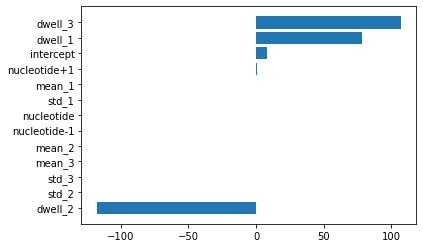

In [149]:
get_logreg_coefficients(nuc_enc_mean_data, clf_list_log_reg[0])

[8.195206029105064,
 0.00926789852387023,
 0.02857558566796783,
 0.2866029433221466,
 77.97003203424494,
 0.040464573217654794,
 0.055325301759350055,
 -117.86403630850536,
 -0.4703274059324356,
 -0.07066006254489338,
 107.09193393736001,
 -0.2722861085452387,
 -0.09642475369186679]

In [129]:
clf = clf_list_log_reg[0]
print(clf.coef_, clf.intercept_)

[[ 9.26789852e-03  2.85755857e-02  2.86602943e-01  7.79700320e+01
   4.04645732e-02  5.53253018e-02 -1.17864036e+02 -4.70327406e-01
  -7.06600625e-02  1.07091934e+02 -2.72286109e-01 -9.64247537e-02]] [8.19520603]


In [100]:
import matplotlib.pyplot as plt
import numpy as np

In [102]:
prepare_train_test_data(nuc_enc_mean_data, 0)[0].index.to_list()

['nucleotide-1',
 'nucleotide',
 'nucleotide+1',
 'dwell_1',
 'std_1',
 'mean_1',
 'dwell_2',
 'std_2',
 'mean_2',
 'dwell_3',
 'std_3',
 'mean_3']

In [107]:
def plot_feat_importance(data, model):
    """
    Pots feature importances given dataset and trained xgboost/tree-based model
    
    data  : encoded dataset of fixed format
    model : trained xgboost/tree-based model
    """
    x_train = prepare_train_test_data(data, 0)[0]
    feat_importance_df = pd.DataFrame({"col_names" : x_train.index.to_list(), 
                  "importance_score" : model.feature_importances_})

    feat_importance_df = feat_importance_df.sort_values(by = "importance_score")

    plt.barh(feat_importance_df["col_names"], feat_importance_df["importance_score"])

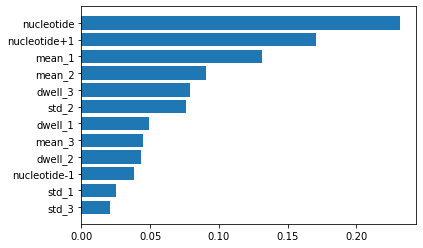

In [108]:
plot_feat_importance(nuc_enc_mean_data, clf_list[0])